In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [2]:
pd.options.display.max_columns = 50

In [3]:
summary = pd.read_csv('data/summary.csv')
day1 = pd.read_csv('data/day 1.csv')

In [4]:
day1.head(20)

,Unnamed: 0,assessment,day,event,patient,time
0,0,NaN,1,arrived,1,280
1,1,NaN,1,arrived,2,288
2,2,NaN,1,assessment initiated,1,308
3,3,NaN,1,arrived,3,430
4,4,urgent|36.599999999999994|no pain,1,assessment concluded,1,741
5,5,NaN,1,assessment initiated,2,764
6,6,NaN,1,consultation_initiated,1,773
7,7,normal|36.699999999999996|severe pain,1,assessment concluded,2,851
8,8,NaN,1,assessment initiated,3,878
9,9,NaN,1,consultation_initiated,2,905


In [5]:
summary.corr()['duration']

Unnamed: 0                -0.043085
arrival_time              -0.034497
assessment_end_time       -0.066131
assessment_start_time     -0.065776
consultation_end_time      0.038430
consultation_start_time   -0.066377
day                       -0.044200
duration                   1.000000
patient                   -0.044809
temperature                0.298949
Name: duration, dtype: float64

In [6]:
# sns.pairplot(summary);

In [7]:
# sns.pairplot(day1);

In [8]:
print(summary.shape)
print(len(summary['Unnamed: 0'].unique()))
print(len(summary['patient'].unique()))

(4420, 12)
4420
4420


In [9]:
summary.head(20)

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,1830,22,113,53,593,137,24,456,no pain,1831,normal,36.7
1,4220,22,113,49,749,193,49,556,no pain,4220,normal,36.8
2,822,8,131,39,1106,169,12,937,moderate pain,820,urgent,37.3
3,386,20,138,55,574,164,6,410,no pain,387,normal,36.7
4,4321,52,161,89,999,208,50,790,moderate pain,4322,urgent,37.1
5,1423,71,176,106,2730,206,19,2524,severe pain,1413,urgent,38.9
6,3926,76,180,100,1058,214,46,843,severe pain,3925,normal,37.4
7,1050,38,196,65,811,231,15,580,moderate pain,1051,normal,37.0
8,3517,17,198,54,1284,248,42,1035,severe pain,3518,normal,37.0
9,3428,0,203,18,966,232,41,734,moderate pain,3429,urgent,36.8


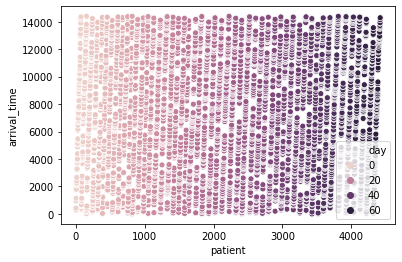

In [10]:
sns.scatterplot('patient', 'arrival_time', data=summary, hue='day');

In [11]:
summary.loc[summary['day'] == 50, 'arrival_time'].corr(summary.loc[summary['day'] == 50, 'patient'])

0.9953782079689507

In [12]:
df = summary.sort_values(['day', 'arrival_time'])

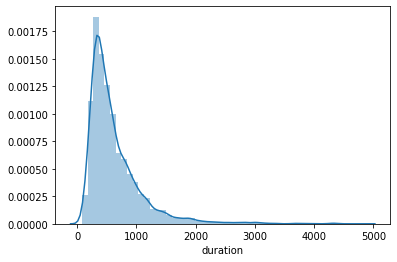

In [13]:
sns.distplot(df['duration']);

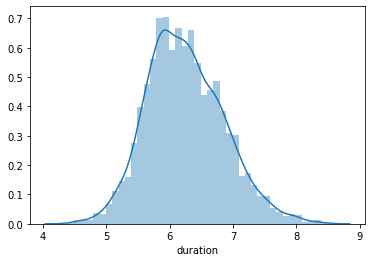

In [14]:
sns.distplot(np.log(df['duration']));

In [15]:
df['log_consult_duration'] = np.log(df['duration'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 131 to 4334
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               4420 non-null   int64  
 1   arrival_time             4420 non-null   int64  
 2   assessment_end_time      4420 non-null   int64  
 3   assessment_start_time    4420 non-null   int64  
 4   consultation_end_time    4420 non-null   int64  
 5   consultation_start_time  4420 non-null   int64  
 6   day                      4420 non-null   int64  
 7   duration                 4420 non-null   int64  
 8   pain                     4420 non-null   object 
 9   patient                  4420 non-null   int64  
 10  priority                 4420 non-null   object 
 11  temperature              4420 non-null   float64
 12  log_consult_duration     4420 non-null   float64
dtypes: float64(2), int64(9), object(2)
memory usage: 483.4+ KB


In [17]:
# df['assessment_duration'] = df['assessment_end_time'] - df['assessment_start_time']

In [18]:
df['temperature'].describe()

count    4420.000000
mean       36.872330
std         0.452982
min        35.900000
25%        36.700000
50%        36.800000
75%        36.925000
max        42.600000
Name: temperature, dtype: float64

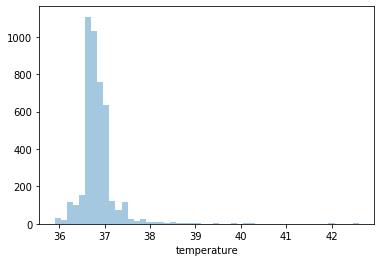

In [19]:
sns.distplot(df['temperature'], kde=False)

In [20]:
df['temp_cat'] = pd.cut(df['temperature'],
                        bins=[float('-inf'), 36.5, 37.5, float('inf')],
                        labels=['hypothermia', 'normal', 'fever'])

In [21]:
priority_map = {'normal': 1, 'urgent': 2}
df['priority_enc'] = df['priority'].map(priority_map)

In [22]:
df = pd.get_dummies(df, columns=['pain', 'temp_cat'])

In [23]:
df

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,patient,priority,temperature,log_consult_duration,priority_enc,pain_moderate pain,pain_no pain,pain_severe pain,temp_cat_hypothermia,temp_cat_normal,temp_cat_fever
131,1,280,741,308,1620,773,1,847,1,urgent,36.6,6.741701,2,0,1,0,0,1,0
162,2,288,851,764,1881,905,1,976,2,normal,36.7,6.883463,1,0,0,1,0,1,0
225,0,430,1055,878,1595,1084,1,510,3,normal,36.8,6.234411,1,0,0,1,0,1,0
278,3,944,1244,1089,2105,1294,1,810,4,urgent,36.6,6.697034,2,0,0,1,0,1,0
302,11,1139,1351,1267,3322,1378,1,1943,5,urgent,36.2,7.571988,2,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4276,4419,13730,15368,15304,18067,15398,50,2668,4416,urgent,35.9,7.889084,2,0,0,1,1,0,0
4300,4415,13893,15547,15403,15850,15584,50,266,4417,normal,36.8,5.583496,1,0,1,0,0,1,0
4312,4417,13931,15680,15583,16304,15703,50,601,4418,normal,36.5,6.398595,1,0,0,1,1,0,0
4326,4416,14147,15829,15698,16162,15856,50,305,4419,normal,36.9,5.720312,1,0,1,0,0,1,0


In [24]:
df['pain_no pain:temp_cat_hypothermia'] = df['pain_no pain'] * df['temp_cat_hypothermia']
df['pain_moderate pain:temp_cat_hypothermia'] = df['pain_moderate pain'] * df['temp_cat_hypothermia']
df['pain_severe pain:temp_cat_hypothermia'] =df['pain_severe pain'] * df['temp_cat_hypothermia']

df['pain_no pain:temp_cat_normal'] = df['pain_no pain'] * df['temp_cat_normal']
df['pain_moderate pain:temp_cat_normal'] = df['pain_moderate pain'] * df['temp_cat_normal']
df['pain_severe pain:temp_cat_normal'] = df['pain_severe pain'] * df['temp_cat_normal']

df['pain_no pain:temp_cat_fever'] = df['pain_no pain'] * df['temp_cat_fever']
df['pain_moderate pain:temp_cat_fever'] = df['pain_moderate pain'] * df['temp_cat_fever']
df['pain_severe pain:temp_cat_fever'] = df['pain_severe pain'] * df['temp_cat_fever']

df.drop(['pain_no pain', 'pain_moderate pain', 'pain_severe pain',
         'temp_cat_hypothermia', 'temp_cat_normal', 'temp_cat_fever',
         'temperature'], axis=1, inplace=True)

In [25]:
cols_to_drop = ['Unnamed: 0', 'consultation_end_time', 'duration', 'arrival_time',
                'assessment_start_time', 'patient', 'priority']
df.drop(cols_to_drop, axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 131 to 4334
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   assessment_end_time                      4420 non-null   int64  
 1   consultation_start_time                  4420 non-null   int64  
 2   day                                      4420 non-null   int64  
 3   log_consult_duration                     4420 non-null   float64
 4   priority_enc                             4420 non-null   int64  
 5   pain_no pain:temp_cat_hypothermia        4420 non-null   uint8  
 6   pain_moderate pain:temp_cat_hypothermia  4420 non-null   uint8  
 7   pain_severe pain:temp_cat_hypothermia    4420 non-null   uint8  
 8   pain_no pain:temp_cat_normal             4420 non-null   uint8  
 9   pain_moderate pain:temp_cat_normal       4420 non-null   uint8  
 10  pain_severe pain:temp_cat_normal         4420 

In [27]:
X_train = df[df['day'] <= 45].drop(['day', 'log_consult_duration'], axis=1)
X_test = df[df['day'] > 45].drop(['day', 'log_consult_duration'], axis=1)
y_train = df.loc[df['day'] <= 45, 'log_consult_duration']
y_test = df.loc[df['day'] > 45, 'log_consult_duration']

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(normalize=True, random_state=42)

ridge_params ={'alpha': ss.uniform(0, 1)}

rscv = RandomizedSearchCV(ridge,
                          ridge_params,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=tscv,
                          verbose=1,
                          random_state=42,
                          return_train_score=True)

rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.1s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=True,
                                   random_state=42, solver='auto', tol=0.001),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd7879d2c50>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=1)

In [29]:
lm = rscv.best_estimator_
lm

Ridge(alpha=0.05808361216819946, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=42, solver='auto', tol=0.001)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
cv_results = pd.DataFrame(rscv.cv_results_)
train_rmse = -cv_results.loc[rscv.best_index_, 'mean_train_score']
val_rmse = -cv_results.loc[rscv.best_index_, 'mean_test_score']

test_rmse = mean_squared_error(y_test, lm.predict(X_test_scaled), squared=False)

print(f'train rmse: {train_rmse}')
print(f'val rmse: {val_rmse}')
print(f'test rmse: {test_rmse}')

train rmse: 0.41647656356287766
val rmse: 0.4584946508325671
test rmse: 1.2046810143855968
